In [119]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import lightkurve as lk
from modules import *
from astropy.table import Table
import scipy.signal as signal
import scipy.optimize as optimize
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from tqdm import tqdm

plt.style.use('seaborn-v0_8-darkgrid')

TIC = 'TIC 304628774'
# TIC = 'TIC 425064757'
# TIC = 'TIC 3547397'
# TIC = 'TIC 17897279'
# TIC = 'TIC 3034524'

cadence_magnifier = 10
cadence = 120
no_test_chunks = 10000

PREPARING THE DATA
-------------

This section downloads the desired lightcurves and performs some preliminary operations on them. The operations are:

- Removing the NaNs
- Removing the big features (like outbursts, etc.)
- Interpolating (or increasing the cadence of) the lightcurves

SearchResult containing 3 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 41 2021   SPOC     120    86408822      0.0
  1 TESS Sector 54 2022   SPOC     120    86408822      0.0
  2 TESS Sector 81 2024   SPOC     120    86408822      0.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54631 entries, 0 to 54630
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    54631 non-null  float64
 1   flux    52732 non-null  float32
dtypes: float32(1), float64(1)
memory usage: 640.3 KB


<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux'>

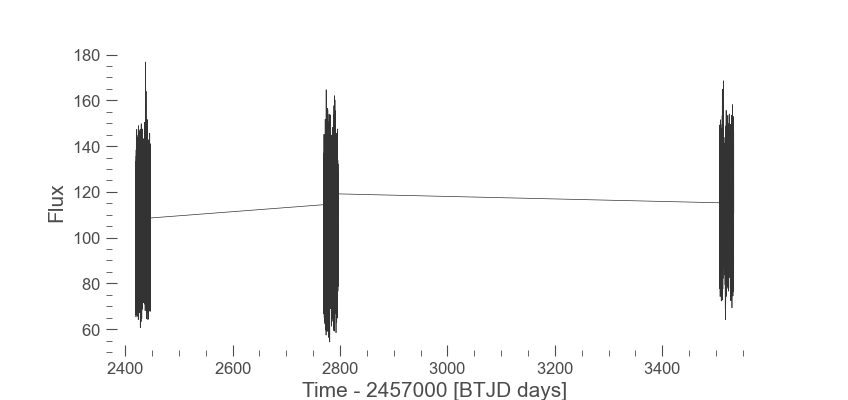

In [120]:
# Gets the lightcurves into a list[Lightcurve]
lcs = get_lightcurves(TIC, author = 'SPOC', cadence='short', use_till=100, use_from=0)
lightcurve = combine_lightcurves(lcs)
lightcurve.plot()

Gaps at times: [2432.60403557]
[ 9070 18321]
Splining values between  2419.994301996194  and  2432.6040355688892
Splining values between  2433.723473550286  and  2446.582971219439
Gaps at times: [2782.34134891]
[ 8944 17898]
Splining values between  2769.903589677997  and  2782.341348908376
Splining values between  2783.5358123988844  and  2796.1330743818544
Gaps at times: [3513.38920161 3514.16420974 3519.21425148 3526.11147745]
[ 4907  5310  7026 11576 16510]
Splining values between  3506.5571425626986  and  3513.389201611746
Splining values between  3513.6058706203476  and  3514.164209737908
Splining values between  3516.803121754434  and  3519.2142514754087
Splining values between  3519.793422936462  and  3526.111477447208
Splining values between  3526.3281428208575  and  3533.180859313812
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 529027 entries, 0 to 529026
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   time

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux'>

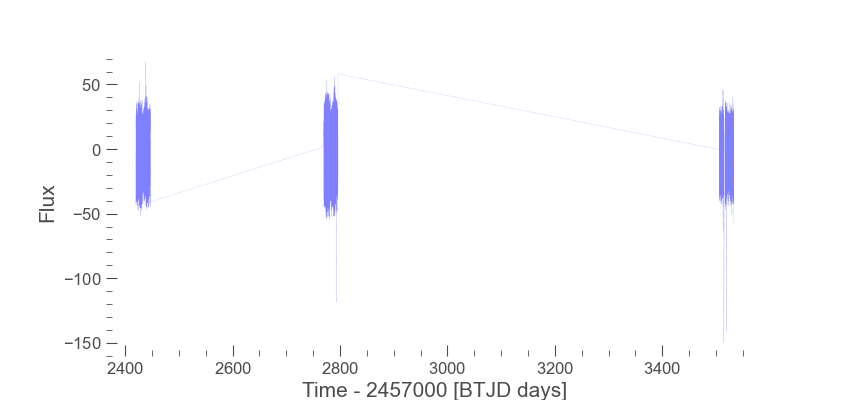

In [121]:
#Preparing the Lightcurves for analysis
new_lcs = []

for lc in lcs:  
    #Removing Nans from the Lightcurves
    df = pd.DataFrame({'time': lc.time.jd, 'flux': np.array(lc.flux, dtype='f')}).dropna(inplace=False)
    new_lc = lk.LightCurve(time= df['time'], flux= df['flux'])

    #new_lc = lc.remove_nans()                  #Potential alternative solution
    
    #Removing the big trends AND increasing the cadence.
    new_lc = apply_savgol_filter(new_lc.time.jd, new_lc.flux, want = 'lc', displaygraphs= False, window_length_for_remove=( 3600*50 )/120, iterations=3)
    new_lc = spline_while_jumping_gaps(new_lc, cadence_magnifier= cadence_magnifier)

    #Storing away the adjusted & splined curve
    new_lcs.append(new_lc)

lightcurve = combine_lightcurves(new_lcs)
lightcurve.plot(color = 'blue', linewidth=0.3, alpha=0.5, linestyle='dotted')

#IMPORTANT Note: The straight lines between gaps seen below are not present in the data, Python adds them just for the graphs to make them visually continuous. The data is not continuous for that part.

In [122]:
'''
Built straight lines between the gaps but tbh, I don't understand why we need straight lines?
When we talk about the periodogram, it's better to use non-interpolated data, right? 
And when we talk about gaussians, it becomes easier to eliminate incomplete(gap containing ones) if we have gaps in data. What the hell?? I guess 5 AM hits different.
'''

#Fill the gaps with straight lines (WHYYY???)

# new_lightcurve = straight_lines(lightcurve, cadence_magnifier= 1)
# axess = new_lightcurve.plot()
# lightcurve.plot(ax= axess, color= 'red')

"\nBuilt straight lines between the gaps but tbh, I don't understand why we need straight lines?\nWhen we talk about the periodogram, it's better to use non-interpolated data, right? \nAnd when we talk about gaussians, it becomes easier to eliminate incomplete(gap containing ones) if we have gaps in data. What the hell?? I guess 5 AM hits different.\n"

FINDING THE PERIOD
-------------

The next section here finds the period to be used for O-C calculations as well as for folding.
A gaussian curve is fit on a Periodogram that is obtained from the desired `lightcurve`.

Please click on the desired peak to make the program process data, the peak should be the tallest peak in the entire mess of principle peak.

PS: Clicking on a point draws a gaussian which is selected for the O-C calculations. If you miss-clicked, just click on the right point afterwards and it will draw a curve in a different color, allowing you to choose another point.

Guessed peak width is 0.00044916101143443674
105753


FigureWidget({
    'data': [{'marker': {'size': 7, 'symbol': 'x'},
              'mode': 'markers',
              'name': 'Peaks',
              'type': 'scatter',
              'uid': 'e67265b5-4dd2-4135-9d39-2f0fccf10daf',
              'x': array([ 1.00038   ,  1.00133   ,  1.00323001, ..., 19.99417009, 19.9970201 ,
                          19.99968011]),
              'y': array([0.29620003, 0.23459335, 0.24916319, ..., 0.19527657, 0.19063835,
                          0.18516758])},
             {'line': {'color': 'black'},
              'mode': 'lines',
              'name': 'Periodogram',
              'type': 'scatter',
              'uid': 'f00d6ed0-c2a3-4dde-aa88-4136e086bca3',
              'x': array([ 1.        ,  1.00017966,  1.00035933, ..., 19.99951078, 19.99969045,
                          19.99987011]),
              'y': array([0.13734655, 0.24368922, 0.29500139, ..., 0.17117668, 0.184996  ,
                          0.1618825 ])}],
    'layout': {'hovermode': 'clo

[1.82602088e+00 1.76404188e+01 3.45467589e-04]


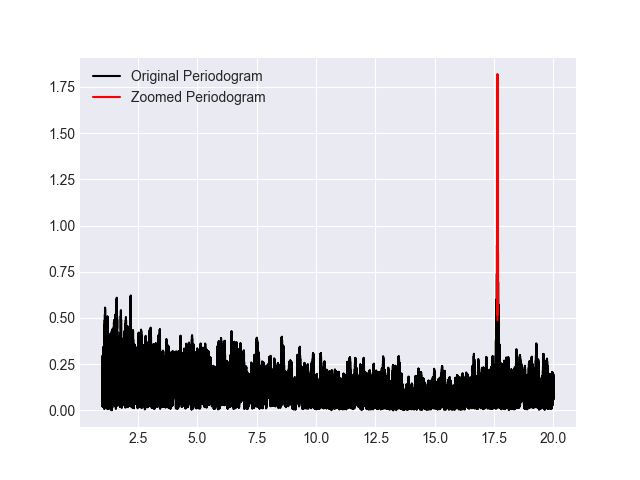

In [123]:
periodogram = lightcurve.to_periodogram(maximum_frequency = 20, minimum_frequency = 1)

peak_width = 1 / ( (lightcurve.time.btjd[-1] - lightcurve.time.btjd[0]) * 2)
print(f'Guessed peak width is {peak_width}')
max_power = periodogram.max_power.value
optimized_parameters_global = []

frequencies = periodogram.frequency.value
print(len(frequencies))
power = periodogram.power.value
f = np.linspace(frequencies.min(), frequencies.max(), 100000)
p = spline(frequencies, power, k = 3)(f)

peaks, peakdict = signal.find_peaks(p, height = max_power/10)
peaks_df = pd.DataFrame({'frequencies': f[peaks], 'power': p[peaks], 'peak_index': peaks})
periodogram_df = pd.DataFrame({'frequencies': f, 'power': p})

fi = go.FigureWidget([
    go.Scatter(x=f[peaks], y=p[peaks], mode = 'markers', name = 'Peaks', marker = {
        'symbol': 'x',
        'size': 7,
    }),
    go.Scatter(x=frequencies, y=power, mode='lines', name = 'Periodogram', line = dict(color='black')),
], layout = go.Layout(title = 'Periodogram Peaks', xaxis_title = 'Frequency [1/d]', yaxis_title = 'Power'))

scatter = fi.data[0]
fi.layout.hovermode = 'closest'

def update_point(trace, points, selector):
    for i in points.point_inds:
        initial_guess = [peaks_df['power'][i], peaks_df['frequencies'][i], peak_width]
        point_freq = peaks_df['frequencies'][i]

        zoomed_df = periodogram_df[periodogram_df['frequencies'].between(point_freq - (1.5*peak_width), point_freq + (1.5*peak_width))]

        fig, ax = plt.subplots()
        ax.plot(f, p, label = "Original Periodogram", color = 'black')
        ax.plot(zoomed_df['frequencies'], zoomed_df['power'], label = "Zoomed Periodogram", color = 'red')
        ax.legend()

        optimized_parameters, covariance = optimize.curve_fit(gaussian, zoomed_df['frequencies'], zoomed_df['power'], p0=initial_guess)
        amp, cen, wid = optimized_parameters

        fitted_gaussian = gaussian(frequencies, amp, cen, wid)
        initial_gaussian = gaussian(frequencies, *initial_guess)

        fi.add_trace(go.Scatter(x=frequencies, y=initial_gaussian, mode='lines', name='Initial Gaussian', line=dict(color=next(color_change()))))
        fi.add_trace(go.Scatter(x=frequencies, y=fitted_gaussian, mode='lines', name='Fitted Gaussian', line=dict(color=next(color_change()))))
        optimized_parameters_global.append(optimized_parameters)
        print(optimized_parameters_global[-1])
    
scatter.on_click(update_point)
fi


In [125]:
try:
    fitted_frequency = optimized_parameters_global[-1][1]
    fitted_period = 1/fitted_frequency
except:
    raise ValueError('No peaks clicked yet, please click on a peak to fit a gaussian to it.')

print(f'Fitted Frequency: {fitted_frequency}')
print(f'Fitted Period: {fitted_period}')

Fitted Frequency: 17.6404187865627
Fitted Period: 0.05668799658893209


In [111]:
fitted_period = 0.2099370750026254 - (5*0.000001157)

DIVIDING INTO CHUNKS
----------

Next part of the code divides the lightcurve into chunks and also removes any chunks that have less that 80% of the average number of values.

In [112]:
#Dividing the lightcurve into chunks, the size of a chunk is the fitted period.
lightcurve_df = pd.DataFrame({'time': lightcurve.time.btjd, 'flux': np.array(lightcurve.flux, dtype='f')})
curr_initial_time = lightcurve_df['time'].iloc[0]
curr_end_time = curr_initial_time + fitted_period

chunks = []
chunk_centres = []

for i in tqdm(range(1, no_test_chunks+1)):
    if curr_end_time > lightcurve_df['time'].iloc[-1]:
        all_chunk_count = i
        break
    else:
        #Only the timestamps between initial_time and end_time are stored inside a chunk.
        chunk = lightcurve_df[(lightcurve_df['time'] >= curr_initial_time) & (lightcurve_df['time'] < curr_end_time)]
        curr_initial_time = curr_end_time
        curr_end_time = curr_initial_time + fitted_period


        #Use only the chunks that are within expected lengths
        expected_length = fitted_period * 86400 / (cadence / cadence_magnifier)
        if (len(chunk) < 1.2 * expected_length) and (len(chunk) > 0.8 * expected_length):
            chunks.append(chunk)
            chunk_centres.append(curr_initial_time - (fitted_period/2))

if not all_chunk_count:
    all_chunk_count = no_test_chunks

chunk_lengths = [len(chunk) for chunk in chunks]
avg_chunk_length = pd.Series(chunk_lengths).mean()

print(f'Number of chunks is {len(chunks)}')
print(f'Mean of chunk lengths is {avg_chunk_length}')


 88%|████████▊ | 8811/10000 [00:39<00:05, 224.66it/s]

Number of chunks is 3131
Mean of chunk lengths is 1509.892047269243


  9%|▉         | 285/3131 [00:04<00:48, 58.58it/s]


KeyboardInterrupt: 

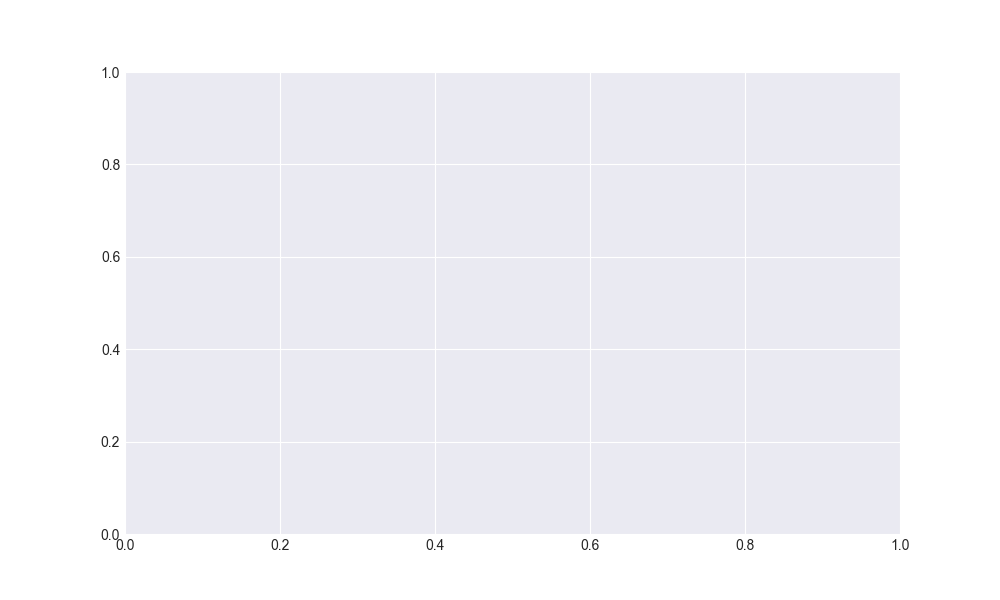

No such comm: a512a17c65b84c1fbba8331a43ce72fc
No such comm: af30583c1f6e47cdb84ebc5cb7d1bf31
No such comm: af30583c1f6e47cdb84ebc5cb7d1bf31
No such comm: af30583c1f6e47cdb84ebc5cb7d1bf31
No such comm: af30583c1f6e47cdb84ebc5cb7d1bf31
No such comm: af30583c1f6e47cdb84ebc5cb7d1bf31
No such comm: af30583c1f6e47cdb84ebc5cb7d1bf31
No such comm: c9a942c16354442ba7a680565053c356
No such comm: c9a942c16354442ba7a680565053c356
No such comm: c9a942c16354442ba7a680565053c356
No such comm: c9a942c16354442ba7a680565053c356
No such comm: c9a942c16354442ba7a680565053c356
No such comm: c9a942c16354442ba7a680565053c356
No such comm: 194ef452aa2a43c2a3d29304520ce803
No such comm: 194ef452aa2a43c2a3d29304520ce803
No such comm: 194ef452aa2a43c2a3d29304520ce803
No such comm: 194ef452aa2a43c2a3d29304520ce803
No such comm: 194ef452aa2a43c2a3d29304520ce803
No such comm: 194ef452aa2a43c2a3d29304520ce803
No such comm: cca144871d8c46d286be3cda98a93486
No such comm: cca144871d8c46d286be3cda98a93486
No such comm:

In [113]:
'''Run to save the chunks as images.'''

for i in tqdm(range(len(chunks))):
    plt.figure(figsize=(10, 6))
    plt.title(f'Chunk {i}')
    plt.plot(chunks[i]['time'], chunks[i]['flux'], lw=0.5)
    plt.axvline(chunk_centres[i], color='red', lw=0.5)
    #plt.savefig(f'AnotherChunks/{i}.png')
    plt.close()

INFORMING THE PROGRAM ABOUT THE POSITION OF THE GAUSSIAN
---------
Click on two points that, according to you, give a good '[Full Width at Half Maximum](https://en.wikipedia.org/wiki/Full_width_at_half_maximum).' The program will use this as an initial guess, majorly for horizontal position. Leave the rest to the Gods and destiny.

Also, the default chunk used as sample is the first one. If you want a different `nth` chunk, enter into `chunk_num`.

PS: You can chose more than once, it will just use your final choice.

In [114]:
chunk_num = 20        #Which chunk to use for testing?

sample_chunk = chunks[chunk_num]
chunk_centre = chunk_centres[chunk_num]
sample_chunk_markers = sample_chunk.iloc[::10, :]

gaussian_peak_width = 0
gaussian_position_relative_to_centre = 0

chunk_fi = go.FigureWidget([
    go.Scatter(x=sample_chunk_markers['time'], y=sample_chunk_markers['flux'], mode='markers', name='Sampled Points', marker= {'symbol': 'bowtie', 'size': 10, 'color':'red'}),
    go.Scatter(x=sample_chunk['time'], y=sample_chunk['flux'], mode='lines', name='Chunk', line=dict(color='blue')),
], layout = go.Layout(title='Sample Chunk', xaxis_title='Time [BTJD]', yaxis_title='Flux', autosize=False, width = 1500, height=700))

chunk_scatter = chunk_fi.data[0]
chunk_fi.layout.hovermode = 'closest'


def first_input(trace, points, selector):
    '''
    This function is used to store the first point clicked in the chunk.
    '''
    global point1_time
    global point1_flux
    point1_time = points.xs[0]
    point1_flux = points.ys[0]

def second_input(trace, points, selector):
    '''
    Takes in the second point clicked and fits a gaussian to the chunk. The main function is to get the peak width and position relative to the centre.
    '''
    global point2_time
    global point2_flux
    global gaussian_peak_width
    global gaussian_position_relative_to_centre
    point2_time = points.xs[0]
    point2_flux = points.ys[0]

    gaussian_peak_width = abs(point2_time - point1_time)
    gaussian_position_relative_to_centre = (point2_time + point1_time)/2 - chunk_centre

    height = 0 - sample_chunk['flux'].min()
    cen = chunk_centre + gaussian_position_relative_to_centre
    width = gaussian_peak_width

    initial_guess = [height, cen, width]
    optimized_parameters, covariance = optimize.curve_fit(inverse_gaussian, sample_chunk['time'], sample_chunk['flux'], p0=initial_guess)
    amp, cen, wid = optimized_parameters

    fitted_gaussian = inverse_gaussian(sample_chunk['time'], amp, cen, wid)
    initial_gaussian = inverse_gaussian(sample_chunk['time'], *initial_guess)

    chunk_fi.add_trace(go.Scatter(x=sample_chunk['time'], y=fitted_gaussian, mode='lines', name='Fitted Gaussian', line=dict(color=next(color_change()))))
    chunk_fi.add_trace(go.Scatter(x=sample_chunk['time'], y=initial_gaussian, mode='lines', name='Initial Gaussian', line=dict(color=next(color_change()))))

current_func = first_input

def toggle_clicker(trace, points, state):
    global current_func
    current_func(trace, points, state)

    # Switch to the other function
    if current_func == first_input:
        current_func = second_input
    else:
        current_func = first_input

chunk_scatter.on_click(toggle_clicker)
chunk_fi



FigureWidget({
    'data': [{'marker': {'color': 'red', 'size': 10, 'symbol': 'bowtie'},
              'mode': 'markers',
              'name': 'Sampled Points',
              'type': 'scatter',
              'uid': '378370e8-1314-41e3-aae8-0ece91e07bb4',
              'x': array([1687.55246541, 1687.55385431, 1687.55524322, 1687.55663212,
                          1687.55802103, 1687.55940993, 1687.56079884, 1687.56218774,
                          1687.56357665, 1687.56496555, 1687.56635446, 1687.56774337,
                          1687.56913227, 1687.57052118, 1687.57191008, 1687.57329899,
                          1687.57468789, 1687.5760768 , 1687.5774657 , 1687.57885461,
                          1687.58024352, 1687.58163242, 1687.58302133, 1687.58441023,
                          1687.58579914, 1687.58718804, 1687.58857695, 1687.58996585,
                          1687.59135476, 1687.59274367, 1687.59413257, 1687.59552148,
                          1687.59691038, 1687.59829929, 

In [115]:
'''Creates a dataframe and a csv file with the chunk data.'''

chunks_df = pd.DataFrame({
    'chunk' : chunks,
    'chunk_number' : [i for i in range(len(chunks))],
    'chunk_len' : [len(chunk) for chunk in chunks],
}).to_csv('chunks.csv', index=False)

chunks[0]

,time,flux
0,1683.353804,11.757935
1,1683.353943,14.938447
2,1683.354082,17.303198
3,1683.354221,18.918676
4,1683.354360,19.851357
...,...,...
1507,1683.563112,-5.037086
1508,1683.563251,-6.003260
1509,1683.563390,-6.987363
1510,1683.563529,-7.976208


FITTING GAUSSIANS INTO CHUNKS
--------

We will take a random guess and try fitting with that guess.

In [116]:
#List to store all the times of the peak of the gaussian.
observed_centers = []

for i in tqdm(range(len(chunks))):
    height = 0 - chunks[i]['flux'].min()
    cen = chunk_centres[i] + gaussian_position_relative_to_centre
    width = gaussian_peak_width

    initial_guess = [height, cen, width]
    try:
        optimized_parameters, covariance = optimize.curve_fit(inverse_gaussian, chunks[i]['time'], chunks[i]['flux'], p0=initial_guess)
        amp, cen, wid = optimized_parameters

        fitted_gaussian = inverse_gaussian(chunks[i]['time'], amp, cen, wid)
        initial_gaussian = inverse_gaussian(chunks[i]['time'], *initial_guess)

        # plt.figure(figsize=(10, 5))
        # plt.title(f'Chunk {i} with Gaussian')
        # plt.grid(False)
        # plt.plot(chunks[i]['time'], chunks[i]['flux'])
        # plt.plot(chunks[i]['time'], fitted_gaussian, color='red')
        # plt.plot(chunks[i]['time'], initial_gaussian, color = 'black', linestyle='--', alpha=0.5)
        # plt.legend(['Chunk', 'Fitted Gaussian', 'Initial Gaussian'])
        # plt.savefig(f'ChunksWithGaussians3034524/{i}.png')
        # plt.close()

        observed_centers.append(cen)
    except:
        print(f"problem at chunk {i}.")
        print(f"Initial guess was {initial_guess[1]}")
        observed_centers.append(initial_guess[1])
        continue

    

 47%|████▋     | 1467/3131 [00:18<00:20, 80.71it/s]

problem at chunk 1467.
Initial guess was 2626.0876945337077


 61%|██████    | 1905/3131 [00:25<00:21, 56.45it/s]

problem at chunk 1894.
Initial guess was 2792.773138795863


 70%|██████▉   | 2183/3131 [00:30<00:25, 37.68it/s]

problem at chunk 2176.
Initial guess was 2867.718609326832


 78%|███████▊  | 2429/3131 [00:34<00:10, 63.82it/s]/var/folders/z0/kkt653vs1rscq9_7hh77yyyr0000gn/T/ipykernel_34685/3067795868.py:11: OptimizeWarning:

Covariance of the parameters could not be estimated

 96%|█████████▌| 3009/3131 [00:43<00:02, 48.91it/s]

problem at chunk 3002.
Initial guess was 3445.239588124299


100%|██████████| 3131/3131 [00:45<00:00, 68.36it/s]


In [117]:
'''Maybe another way of fitting the gaussians?'''
observed_centers = []

for i in tqdm(range(len(chunks))):
# for i in tqdm(range(100)):
    height = 0 - chunks[i]['flux'].min()
    cen = chunk_centres[i] + gaussian_position_relative_to_centre
    width = gaussian_peak_width

    relevant_chunk = chunks[i][ chunks[i]['time'].between(cen - (2.5*width), cen + (3*width)) ]

    initial_guess = [height, cen, width]
    try:
        optimized_parameters, covariance = optimize.curve_fit(inverse_gaussian, relevant_chunk['time'], relevant_chunk['flux'], p0=initial_guess)
        amp, cen, wid = optimized_parameters

        fitted_gaussian = inverse_gaussian(chunks[i]['time'], amp, cen, wid)
        initial_gaussian = inverse_gaussian(chunks[i]['time'], *initial_guess)

        # plt.figure(figsize=(10, 5))
        # plt.title(f'Chunk {i} with Gaussian (Focused)')
        # plt.grid(False)
        # plt.plot(chunks[i]['time'], chunks[i]['flux'])
        # plt.plot(relevant_chunk['time'], relevant_chunk['flux'], color='green')
        # plt.plot(chunks[i]['time'], fitted_gaussian, color='red')
        # plt.plot(chunks[i]['time'], initial_gaussian, color = 'black', linestyle='--', alpha=0.5)
        # plt.legend(['Chunk', 'Fitted Gaussian', 'Initial Gaussian'])
        # plt.savefig(f"ChunksWithGaussians3034524/{i} 'focused'.png")
        # plt.close()

        observed_centers.append(cen)
    except:
        print(f"problem at chunk {i}.")
        print(f"Initial guess was {initial_guess[1]}")
        observed_centers.append(initial_guess[1])
        continue

 61%|██████    | 1910/3131 [00:25<00:22, 53.72it/s] 

problem at chunk 1894.
Initial guess was 2792.773138795863


 62%|██████▏   | 1955/3131 [00:26<00:22, 52.10it/s]/var/folders/z0/kkt653vs1rscq9_7hh77yyyr0000gn/T/ipykernel_34685/4220462036.py:14: OptimizeWarning:

Covariance of the parameters could not be estimated

100%|██████████| 3131/3131 [00:48<00:00, 64.68it/s]


The O-C, FINALLY!
------------

Just let it run, don't sweat.

T_0 index is 1416


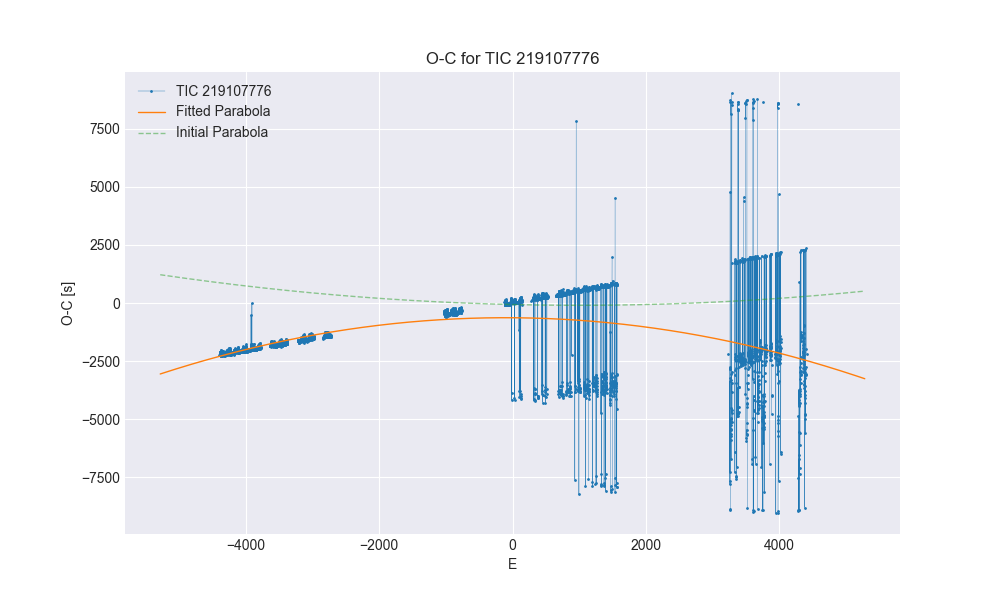

In [118]:
lightcurve_test = lightcurve_df[: int(avg_chunk_length * no_test_chunks)]

O_C_df = pd.DataFrame(
    {
    'E' : [x for x in range(int(-0.6 * all_chunk_count ), int(0.6 * all_chunk_count))]
    }
)

#Finding the T_0 for Event number 0
centre = (lightcurve_test['time'].min() + lightcurve_test['time'].max())/2
T_0_index = np.searchsorted(observed_centers, centre, side='left') - 1
print(f'T_0 index is {T_0_index}')

O_C_df['C'] = observed_centers[T_0_index] + O_C_df['E'] * fitted_period

# Insert observed_centers[i] at E = int((observed_centers[i] - observed_centers[T_0_index])/fitted_period), fill the rest with NaN
O_C_df['O'] = np.nan
for i in range(len(observed_centers)):
    E_value = int(round((observed_centers[i] - observed_centers[T_0_index]) / fitted_period))
    if E_value in O_C_df['E'].values:
        O_C_df.loc[O_C_df['E'] == E_value, 'O'] = observed_centers[i]

O_C_df['O-C'] = (O_C_df['O'] - O_C_df['C']) * 86400
# O_C_df = O_C_df.dropna(inplace=False)

def parabola(x, a, b, c):
    return a*(x**2) + b*x + c

another_O_C = O_C_df.dropna(inplace=False)

initial_guess = [(1/30000), -(1/15), -66]
optimized_parameters, covariance = optimize.curve_fit(parabola, another_O_C['E'], another_O_C['O-C'], p0=initial_guess)

fitted_parabola = parabola(O_C_df['E'], *optimized_parameters)
initial_parabola = parabola(O_C_df['E'], *initial_guess)


fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(O_C_df['E'], O_C_df['O-C'], lw=0.3, marker='o', markersize=1, label = TIC)
ax.plot(O_C_df['E'], fitted_parabola, lw=1, label = 'Fitted Parabola')
ax.plot(O_C_df['E'], initial_parabola, lw=1, label = 'Initial Parabola', linestyle='--', alpha=0.5)
ax.legend()
ax.set_title(f'O-C for {TIC}')
ax.set_xlabel('E')
ax.set_ylabel('O-C [s]')

O_C_df.to_csv('O_C_df.csv', index=False)

In [42]:
print(optimized_parameters)

[-9.03431561e-05 -1.93973389e-02 -6.34303665e+02]


In [45]:
P_dot = (2*-9.03431561e-05)/(0.2099*86400)
print(P_dot)

-9.963205152806451e-09
